In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

Dataset 1 shape: (2405374, 2)
-Dataset examples-
         Cust_Id  Rating
0         387418     1.0
5000     1011758     1.0
10000    2147527     1.0
15000     173264     1.0
20000     628670     1.0
...          ...     ...
2385000  2352698     5.0
2390000   490124     5.0
2395000   867402     5.0
2400000   684876     5.0
2405000  1035795     5.0

[482 rows x 2 columns]


/var/folders/87/dhv__9sj0yv1kz0pfv2ds9nh0000gn/T/ipykernel_10887/229338635.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count = df.isnull().sum()[1]
/var/folders/87/dhv__9sj0yv1kz0pfv2ds9nh0000gn/T/ipykernel_10887/229338635.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


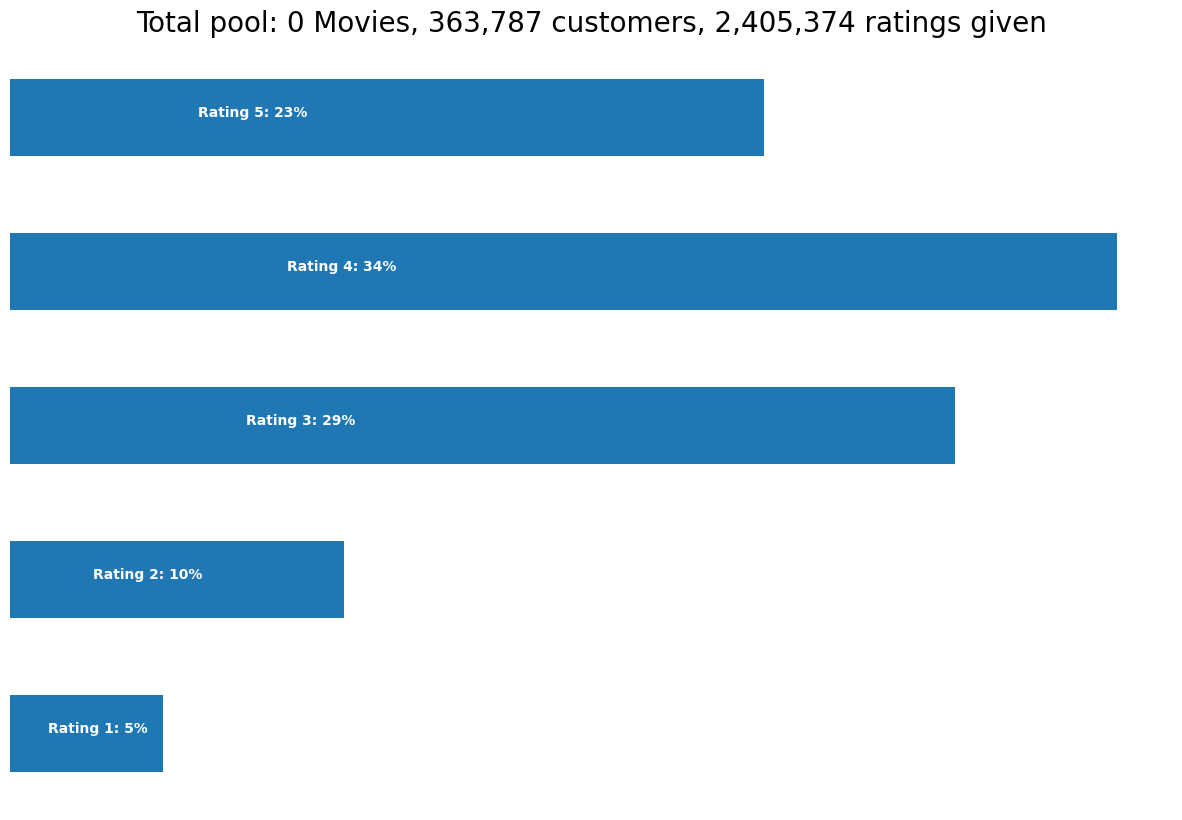

In [2]:
df = pd.read_csv('archive//combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
sample_size = int(len(df) * 0.1)

# Stratified sampling to maintain rating distribution
df = df.groupby('Rating', group_keys=False).apply(
    lambda x: x.sample(n=int(sample_size * len(x)/len(df)))
).reset_index(drop=True)


df['Rating'] = df['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000, :])
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [3]:
# Load and sample data
df = pd.read_csv('archive//combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
sample_size = int(len(df) * 0.01)
df = df.groupby('Rating', group_keys=False).apply(
    lambda x: x.sample(n=int(sample_size * len(x)/len(df)))
).reset_index(drop=True)
df['Rating'] = df['Rating'].astype(float)

# Create movie IDs
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

# Handle case where df_nan might be empty
if len(df_nan) > 0:
    movie_np = []
    movie_id = 1
    for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
        temp = np.full((1,i-j-1), movie_id)
        movie_np = np.append(movie_np, temp)
        movie_id += 1
    
    last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
    movie_np = np.append(movie_np, last_record)
    
    # Process dataframe
    df = df[pd.notnull(df['Rating'])]
    df['Movie_Id'] = movie_np.astype(int)
    df['Cust_Id'] = df['Cust_Id'].astype(int)
    
    # Calculate benchmarks and trim data
    df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(['count','mean'])
    df_movie_summary.index = df_movie_summary.index.map(int)
    movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
    drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
    
    df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(['count','mean'])
    df_cust_summary.index = df_cust_summary.index.map(int)
    cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
    drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
    
    # Trim the dataset
    df = df[~df['Movie_Id'].isin(drop_movie_list)]
    df = df[~df['Cust_Id'].isin(drop_cust_list)]
else:
    print("No movie IDs found in the sample. Consider increasing the sample size.")

No movie IDs found in the sample. Consider increasing the sample size.


In [4]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
import pandas as pd

# Define the file path
file_path = 'archive/movie_titles.csv'

# Read the CSV file with custom parsing
def read_custom_csv(file_path):
    data = []
    with open(file_path, encoding="latin1") as file:
        for line in file:
            # Split the line by commas, handling the case where there might be extra commas
            parts = line.strip().split(',', 2)
            if len(parts) == 3:
                movie_id, year, name = parts
                data.append([movie_id, year, name])
            else:
                print(f"Skipping malformed line: {line.strip()}")
    
    return pd.DataFrame(data, columns=['Movie_Id', 'Year', 'Name'])

# Read and process the custom CSV
df_title = read_custom_csv(file_path)
print(df_title.head(10))

KeyError: 'Movie_Id'

In [5]:
import pandas as pd
from surprise import Reader, Dataset, SVD, KNNBasic, NMF
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
# Train the algorithms
trainset = data.build_full_trainset()
SVD().fit(trainset)
NMF().fit(trainset)


In [6]:
SVD().fit(trainset)

KeyboardInterrupt: 

In [ ]:
# KNNBasic().fit(trainset)


In [ ]:
NMF().fit(trainset)

In [ ]:
# Define the user for whom we want recommendations
user_id = 785314

# Create a copy of the movie titles DataFrame
user_recommendations = df_title.copy()
user_recommendations = user_recommendations.reset_index()

# Remove movies that the user has already rated
rated_movies = df[df['Cust_Id'] == user_id]['Movie_Id']
user_recommendations = user_recommendations[~user_recommendations['Movie_Id'].isin(rated_movies)]

# Function to get the average estimated score from all algorithms
def get_average_score(user_id, movie_id):
    scores = [algo.predict(user_id, movie_id).est for algo in algorithms.values()]
    return sum(scores) / len(scores)

# Get the estimated scores for each movie
user_recommendations['Estimate_Score'] = user_recommendations['Movie_Id'].apply(lambda x: get_average_score(user_id, x))

# Sort the movies by the estimated score
user_recommendations = user_recommendations.drop('Movie_Id', axis=1)
user_recommendations = user_recommendations.sort_values('Estimate_Score', ascending=False)

# Print the top 10 recommendations
print(user_recommendations.head(10))